# basic tests

In [1]:
from PandaStation import PandaStation


# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])

# Let's do all of our imports here, too.
import numpy as np
import ipywidgets
import pydot
import pydrake.all
import os
from IPython.display import display, SVG



import pydrake.all
from pydrake.all import RigidTransform, RotationMatrix, AngleAxis

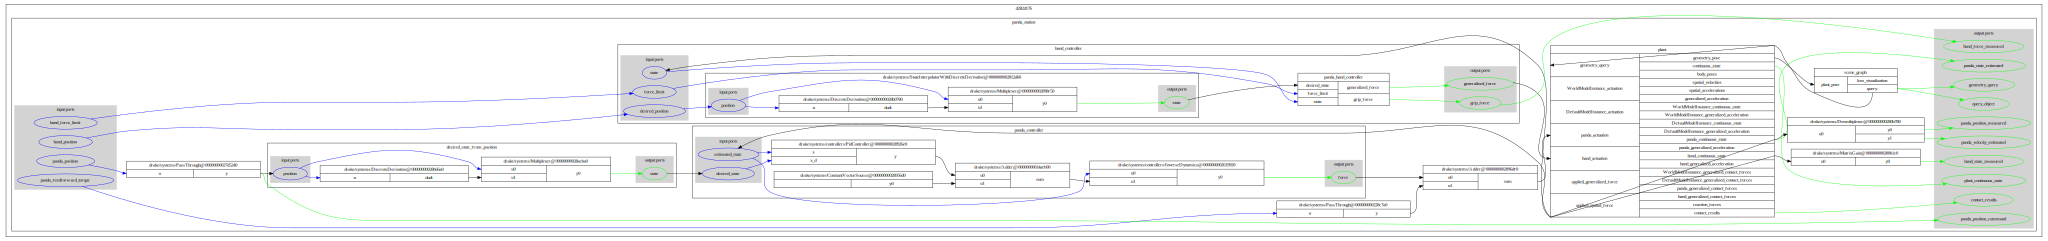

True

In [2]:
builder = pydrake.systems.framework.DiagramBuilder()
station = builder.AddSystem(PandaStation())
station.SetupDefaultStation()
station.Finalize()
diagram = builder.Build()



display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_png("./media/pictures/panda_station.png")

In [3]:
def TestWithMeshcat():
    builder = pydrake.systems.framework.DiagramBuilder()
    station = builder.AddSystem(PandaStation())
    station.SetupDefaultStation()
    station.Finalize()

    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, output_port=station.GetOutputPort("geometry_query"), zmq_url=zmq_url)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    visualizer.load(visualizer.GetMyContextFromRoot(context))
    diagram.Publish(context)

TestWithMeshcat()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


# Testing basic control

In [4]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(pydrake.systems.framework.LeafSystem):
    def __init__(self, plant):
        pydrake.systems.framework.LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("panda")
        self._G = plant.GetBodyByName("panda_hand").body_frame()
        self._W = plant.world_frame()

        self.DeclareVectorInputPort("panda_position", pydrake.systems.framework.BasicVector(7))
        self.DeclareVectorOutputPort("panda_velocity", pydrake.systems.framework.BasicVector(7), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, pydrake.multibody.tree.JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,0:7] # Ignore gripper terms
        
        V_G_desired = np.array([0,    # rotation about x
                                -.1,  # rotation about y
                                0,    # rotation about z
                                0,    # x
                                -.05, # y
                                -.1]) # z
        v = np.linalg.pinv(J_G).dot(V_G_desired)
        output.SetFromVector(v)

        
def jacobian_controller_example():
    builder = pydrake.systems.framework.DiagramBuilder()

    station = builder.AddSystem(PandaStation())
    station.SetupDefaultStation()
    station.Finalize()

    controller = builder.AddSystem(PseudoInverseController(
        station.get_multibody_plant()))
    integrator = builder.AddSystem(pydrake.systems.primitives.Integrator(7))

    builder.Connect(controller.get_output_port(), 
                    integrator.get_input_port())
    builder.Connect(integrator.get_output_port(),
                    station.GetInputPort("panda_position"))
    builder.Connect(station.GetOutputPort("panda_position_measured"),
                    controller.get_input_port())

    meshcat =pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("query_object"),
        zmq_url=zmq_url)

    diagram = builder.Build()
    simulator = pydrake.systems.analysis.Simulator(diagram)
    station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
    #station.GetInputPort("panda_feedforward_torque").FixValue(station_context, np.zeros((7,1))) // this will already be 0
    station.GetInputPort("hand_position").FixValue(station_context, [0.08]) # taking the desired hand separation
    # TODO(russt): Add this missing python binding
    #integrator.set_integral_value(
    #    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
    #        station.GetIiwaPosition(station_context))
    integrator.GetMyContextFromRoot(
        simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(
        station.GetPandaPosition(station_context))

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01);

    return simulator

simulator = jacobian_controller_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


In [5]:
simulator.AdvanceTo(5.0)

# testing pick and place

### create controller

In [15]:
class PseudoInverseController(pydrake.systems.framework.LeafSystem):
    def __init__(self, plant):
        pydrake.systems.framework.LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._panda = plant.GetModelInstanceByName("panda")
        self._G = plant.GetBodyByName("panda_hand").body_frame()
        self._W = plant.world_frame()

        self.w_G_port = self.DeclareVectorInputPort("omega_WG", pydrake.systems.framework.BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_WG", pydrake.systems.framework.BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("panda_position", pydrake.systems.framework.BasicVector(7))
        self.DeclareVectorOutputPort("panda_velocity", pydrake.systems.framework.BasicVector(7), 
                                     self.CalcOutput)

        self.panda_start = plant.GetJointByName("panda_joint1").velocity_start()
        self.panda_end = plant.GetJointByName("panda_joint7").velocity_start()

    def CalcOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._panda, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, pydrake.multibody.tree.JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.panda_start:self.panda_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

### Create gripper frames

In [16]:
def make_gripper_frames(X_G, X_O):
  """
  Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
  returns a X_G and times with all of the pick and place frames populated.
  """
  # Define (again) the gripper pose relative to the object when in grasp.
  p_GgraspO = [0, 0, 0.12]
  R_GgraspO = RotationMatrix.MakeXRotation(np.pi)
  X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
  X_OGgrasp = X_GgraspO.inverse()
  # pregrasp is negative y in the gripper frame (see the figure!).
  X_GgraspGpregrasp = RigidTransform([0, 0, -0.08])

  X_G["pick"] = X_O["initial"].multiply(X_OGgrasp)
  X_G["prepick"] = X_G["pick"].multiply(X_GgraspGpregrasp)
  X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
  X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

  # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
  X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
  angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
  X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
                                        X_GprepickGpreplace.translation()/2.0 + np.array([0, 0, -0.4]))
  X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

  # Now let's set the timing
  times = {"initial": 0}
  X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
  times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
  # Allow some time for the gripper to close.
  times["pick_start"] = times["prepick"] + 2.0
  times["pick_end"] = times["pick_start"] + 2.0
  times["postpick"] = times["pick_end"] + 2.0
  time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
  times["clearance"] = times["postpick"] + time_to_from_clearance
  times["preplace"] = times["clearance"] + time_to_from_clearance
  times["place_start"] = times["preplace"] + 2.0
  times["place_end"] = times["place_start"] + 2.0
  times["postplace"] = times["place_end"] + 2.0

  return X_G, times

X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi), [0, -0.25, 0.25])}
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

Sanity check: The entire maneuver will take 31.899582791758867 seconds to execute.


### Visualize gripper frame

In [17]:
def visualize_gripper_frames(X_G, X_O):
    builder = pydrake.systems.framework.DiagramBuilder()

    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = pydrake.multibody.parsing.Parser(plant, scene_graph)
    gripper = pydrake.common.FindResourceOrThrow(
        "drake/manipulation/models/franka_description/urdf/hand.urdf")
    brick = pydrake.common.FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
    for key, pose in X_G.items():
      g = parser.AddModelFromFile(gripper, f"gripper_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_hand", g), pose)
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)

    plant.Finalize()


    meshcat = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    meshcat.load()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

visualize_gripper_frames(X_G, X_O)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6006...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


### Pick and place trajectories

In [18]:
def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    traj = pydrake.trajectories.PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    
    traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

traj_p_G = make_gripper_position_trajectory(X_G, times)

In [19]:
def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = pydrake.trajectories.PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    traj.Append(times["pick_start"], X_G["pick"].rotation())
    traj.Append(times["pick_end"], X_G["pick"].rotation())
    traj.Append(times["postpick"], X_G["prepick"].rotation())
    traj.Append(times["clearance"], X_G["clearance"].rotation())
    traj.Append(times["preplace"], X_G["preplace"].rotation())
    traj.Append(times["place_start"], X_G["place"].rotation())
    traj.Append(times["place_end"], X_G["place"].rotation())
    traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj

traj_R_G = make_gripper_orientation_trajectory(X_G, times)

In [20]:
opened = np.array([0.08]);
closed = np.array([0.0]);

def make_hand_command_trajectory(times):
    traj_hand_command = pydrake.trajectories.PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]], np.hstack([[opened], [opened]]))
    traj_hand_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_hand_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_hand_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_hand_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_hand_command

traj_hand_command = make_hand_command_trajectory(times)

### testing pick and place

In [ ]:
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.65, 0.09]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.5, 0, 0.09])}

builder = pydrake.systems.framework.DiagramBuilder()

station = builder.AddSystem(PandaStation())
station.SetupBinStation()
station.AddManipulandFromFile(
    "drake/examples/manipulation_station/models/061_foam_brick.sdf",
    X_O["initial"])

station.AddManipulandFromFile(
    "drake/examples/manipulation_station/models/061_foam_brick.sdf",
    RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.1, -.65, 0.09]))

station.AddManipulandFromFile(
    "drake/examples/manipulation_station/models/061_foam_brick.sdf",
    RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.3, -.65, 0.09]))

plant = station.get_multibody_plant()

station.Finalize()

# Find the initial pose of the gripper (as set in the default Context)
station_context = station.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(station_context)
X_G = {"initial": plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("panda_hand"))}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

# Make the trajectories
traj_p_G = make_gripper_position_trajectory(X_G, times)
traj_v_G = traj_p_G.MakeDerivative()
traj_R_G = make_gripper_orientation_trajectory(X_G, times)
traj_w_G = traj_R_G.MakeDerivative()

v_G_source = builder.AddSystem(pydrake.systems.primitives.TrajectorySource(traj_v_G))
v_G_source.set_name("v_WG")
w_G_source = builder.AddSystem(pydrake.systems.primitives.TrajectorySource(traj_w_G))
w_G_source.set_name("omega_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))
builder.Connect(w_G_source.get_output_port(), controller.GetInputPort("omega_WG"))

integrator = builder.AddSystem(pydrake.systems.primitives.Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), 
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("panda_position"))
builder.Connect(station.GetOutputPort("panda_position_measured"),
                controller.GetInputPort("panda_position"))

traj_hand_command = make_hand_command_trajectory(times)
hand_source = builder.AddSystem(pydrake.systems.primitives.TrajectorySource(traj_hand_command))
hand_source.set_name("hand_command")
builder.Connect(hand_source.get_output_port(), station.GetInputPort("hand_position"))

meshcat = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder,
    station.get_scene_graph(),
    output_port=station.GetOutputPort("query_object"),
    zmq_url=zmq_url
)

diagram = builder.Build()
diagram.set_name("pick_and_place")
diagram_context = diagram.CreateDefaultContext()

simulator = pydrake.systems.analysis.Simulator(diagram, diagram_context)
station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())

integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetPandaPosition(station_context))

simulator.set_target_realtime_rate(1.0)
meshcat.start_recording()
simulator.AdvanceTo(traj_p_G.end_time())
meshcat.stop_recording()
meshcat.publish_recording()

Sanity check: The entire maneuver will take 35.567723750562024 seconds to execute.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6006...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


In [14]:
file = open("test.html", "w")
file.write(meshcat.vis.static_html())
file.close()